In [71]:
cd /home/schlecker/repos/planeteScripts

/home/schlecker/repos/planeteScripts


In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import output
import plots
import stats
import utils
import config

%load_ext autoreload
%autoreload 2

# default output folder
outputs = '/home/schlecker/phd/planete/outputs/pop06_MstarGrid/'

pd.set_option('display.max_columns', 500)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Read ref_reds into a list of populations

In [79]:
filenames = ['ref_red5e9_0.3Msol.dat', 'ref_red5e9_0.5Msol.dat', 'ref_red5e9_0.7Msol.dat', 'ref_red5e9_1.0Msol.dat'] 
populations = [output.Population(outputs + f, name=f[11:18]) for f in filenames]

In [95]:
planets0m3 = populations[1].data

concatenate population data into a single multiindex-dataframe

In [10]:
jointdf = pd.concat([pop.data for pop in populations], axis=0, keys=[pop.name for pop in populations])

In [ ]:
jointdf

not yet sure what to do with this... lets get some stats

In [12]:
stats = {p.name : p.get_typeStats() for p in populations}

In [13]:
stats['0.5Msol']

,Earth,SuperEarth,all,ltEarth
Nplanets,1499.000000,1990.000000,9999.000000,4565.000000
Nsystems,1499.000000,1990.000000,9999.000000,4565.000000
fractionSystems,0.149915,0.199020,1.000000,0.456546
meanEccentricity,0.000000,0.000000,0.000000,0.000000
meanMetallicity,-0.013421,-0.003380,-0.023330,0.028433
multiplicity,1.000000,1.000000,1.000000,1.000000
occurrence,0.149915,0.199020,1.000000,0.456546
stdEccentricity,0.000000,0.000000,0.000000,0.000000
stdMetallicity,0.211481,0.215307,0.218326,0.213449


In [14]:
for planetType in stats['0.5Msol']:
    print(planetType)

Earth
SuperEarth
all
ltEarth


how about a summary plot?

In [15]:
def plot_typeStats(populations):
    """
    
    """
    if isinstance(populations, list):
        stats = {p.name : p.get_typeStats() for p in populations}
        fig, ax = plt.subplots()
        stellarMasses = [0.3, 0.5, 0.7, 1.0]
        for M, Mstar in enumerate(stats.keys()):
            for planetType in stats[Mstar]:
                plt.errorbar(stellarMasses[M], stats[Mstar][planetType]['meanMetallicity'], stats[Mstar][planetType]['stdMetallicity'],
                             capsize=40., fmt='o', label=planetType)
        plt.legend()

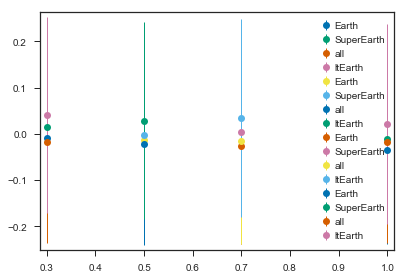

In [16]:
plot_typeStats(populations)

wow, this is ugly. let's try something else

In [12]:
for Mstar, MPop in jointdf.groupby(level=0):

SyntaxError: unexpected EOF while parsing (<ipython-input-12-6d39a49bf851>, line 1)

In [17]:
sns.catplot(x=Mstar, y='Metallicity', kind='bar', data=jointdf)

AttributeError: module 'seaborn' has no attribute 'catplot'